{{< pagebreak >}}

## New York Stock Exchange (NYSE) Data (1962-1986) (10pts)

The [`NYSE.csv`](https://raw.githubusercontent.com/ucla-econ-425t/2023winter/master/slides/data/NYSE.csv) file contains three daily time series from the New York Stock Exchange (NYSE) for the period Dec 3, 1962-Dec 31, 1986 (6,051 trading days).

- `Log trading volume` ($v_t$): This is the fraction of all outstanding shares that are traded on that day, relative to a 100-day moving average of past turnover, on the log scale.
    
- `Dow Jones return` ($r_t$): This is the difference between the log of the Dow Jones Industrial Index on consecutive trading days.
    
- `Log volatility` ($z_t$): This is based on the absolute values of daily price movements.

The **autocorrelation** at lag $\ell$ is the correlation of all pairs $(v_t, v_{t-\ell})$ that are $\ell$ trading days apart. These sizable correlations give us confidence that past values will be helpful in predicting the future.

Below are ACF plots for `Log trading volume`, `Dow Jones return`, and `Log volatility`.

In [60]:
# Package Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import requests

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import keras.backend as K

# Figure Resolution
%matplotlib inline
plt.rcParams['figure.dpi']= 300
sns.set(rc={"figure.dpi":300})
# Set font sizes in plots
sns.set(font_scale = 1.)
# Display all columns
pd.set_option('display.max_columns', None)

In [2]:
# Read in NYSE data from url
url = "https://raw.githubusercontent.com/ucla-econ-425t/2023winter/master/slides/data/NYSE.csv"
s = requests.get(url).content.decode('utf-8')
NYSE = pd.read_csv(io.StringIO(s), index_col = 0)
NYSE

,day_of_week,DJ_return,log_volume,log_volatility,train
date,,,,,
1962-12-03,mon,-0.004461,0.032573,-13.127403,True
1962-12-04,tues,0.007813,0.346202,-11.749305,True
1962-12-05,wed,0.003845,0.525306,-11.665609,True
1962-12-06,thur,-0.003462,0.210182,-11.626772,True
1962-12-07,fri,0.000568,0.044187,-11.728130,True
...,...,...,...,...,...
1986-12-24,wed,0.006514,-0.236104,-9.807366,False
1986-12-26,fri,0.001825,-1.322425,-9.906025,False
1986-12-29,mon,-0.009515,-0.371237,-9.827660,False


Below we will create plots to show the autocorrelation of `Log Volume`, $v_t$, against  the lags of all of our considered features. In particular, we will consider a maximum lag of 20 days in these plots.

<Figure size 900x900 with 0 Axes>

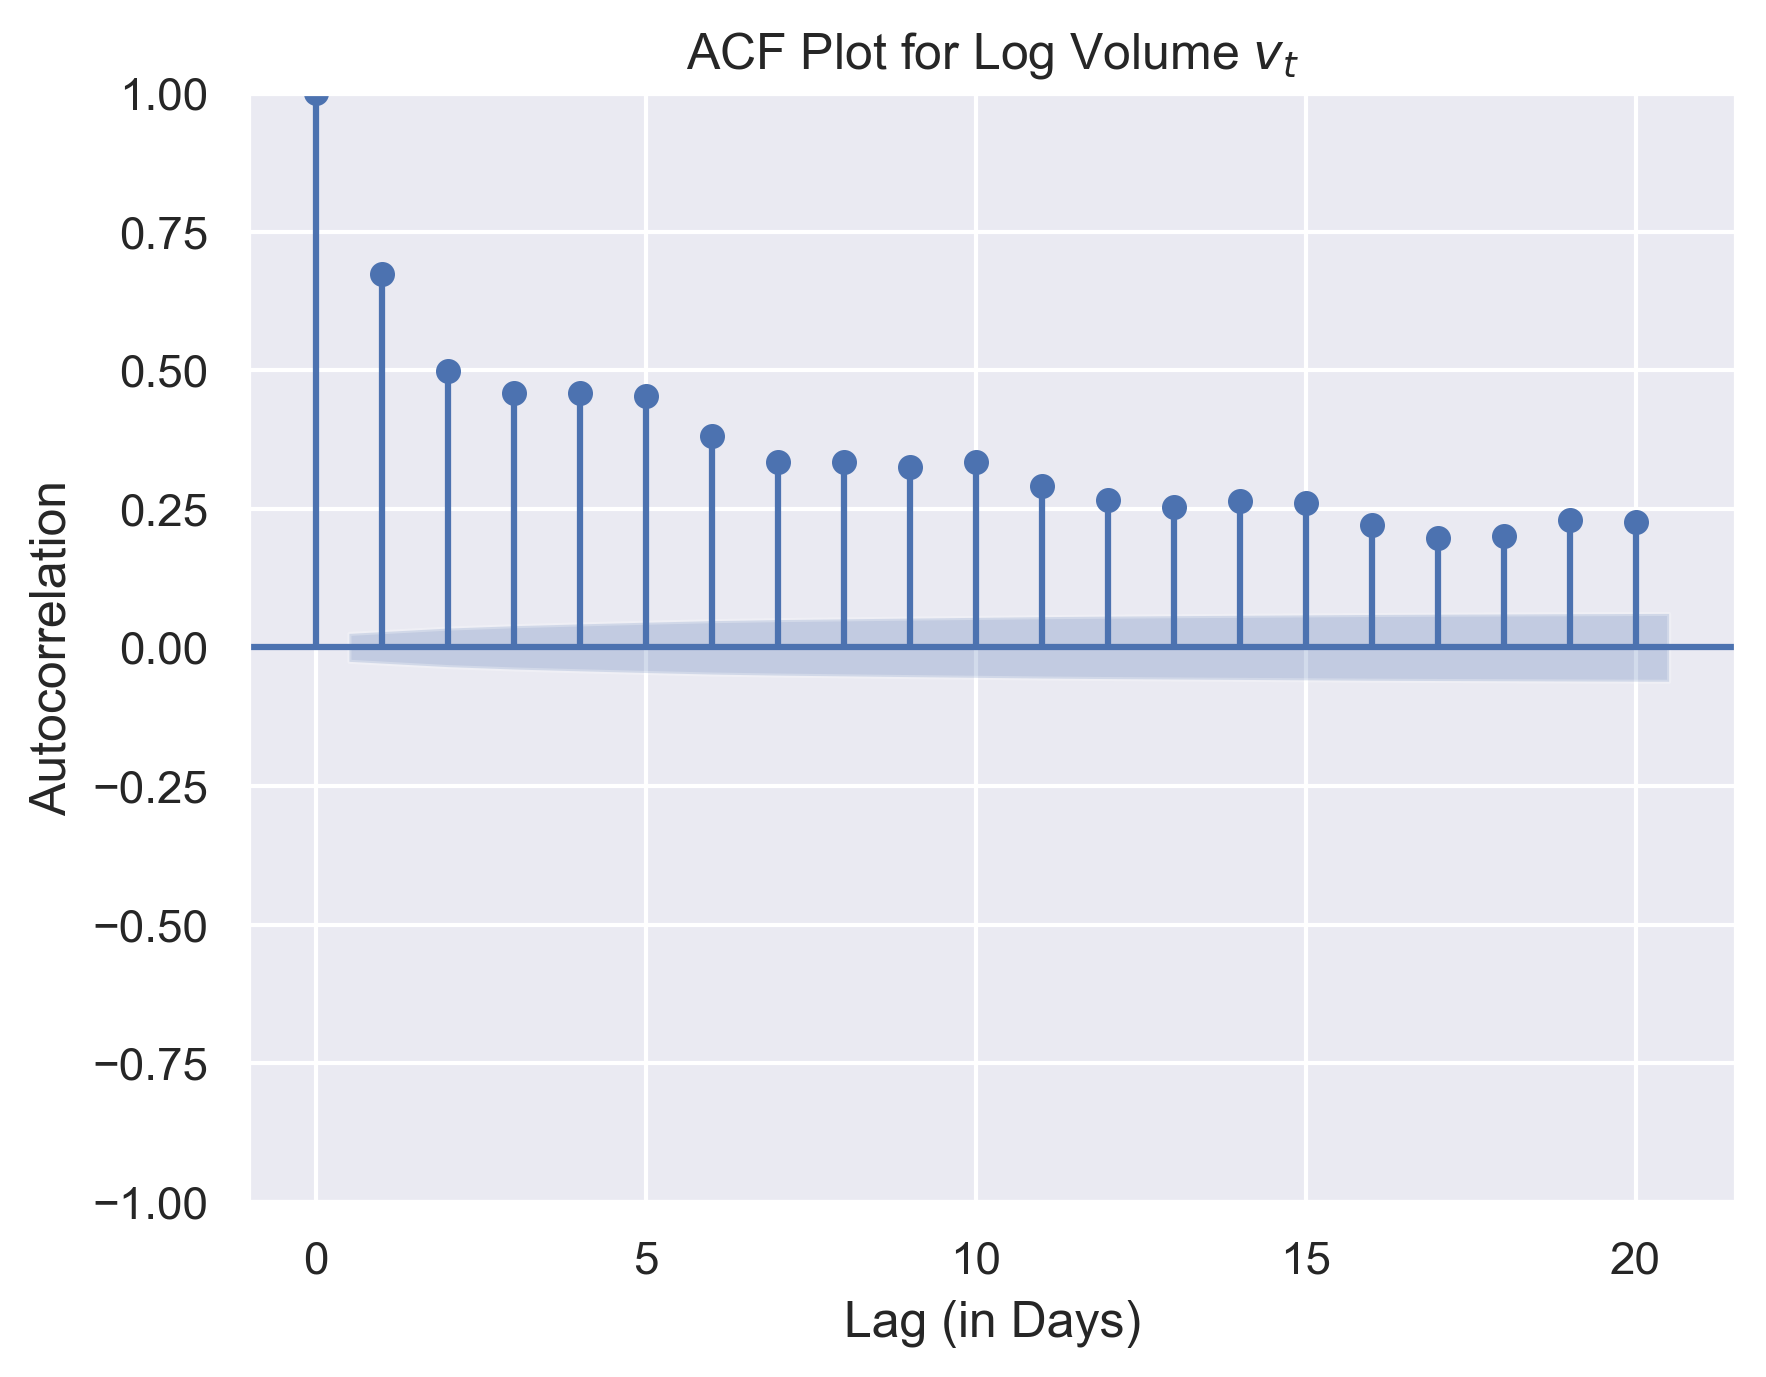

In [3]:
# Log Volume ACF Plot
plt.figure(figsize=(3,3))
plot_acf(NYSE['log_volume'], lags = 20)
plt.title('ACF Plot for Log Volume $v_t$')
plt.xlabel('Lag (in Days)')
plt.ylabel('Autocorrelation')
plt.show()

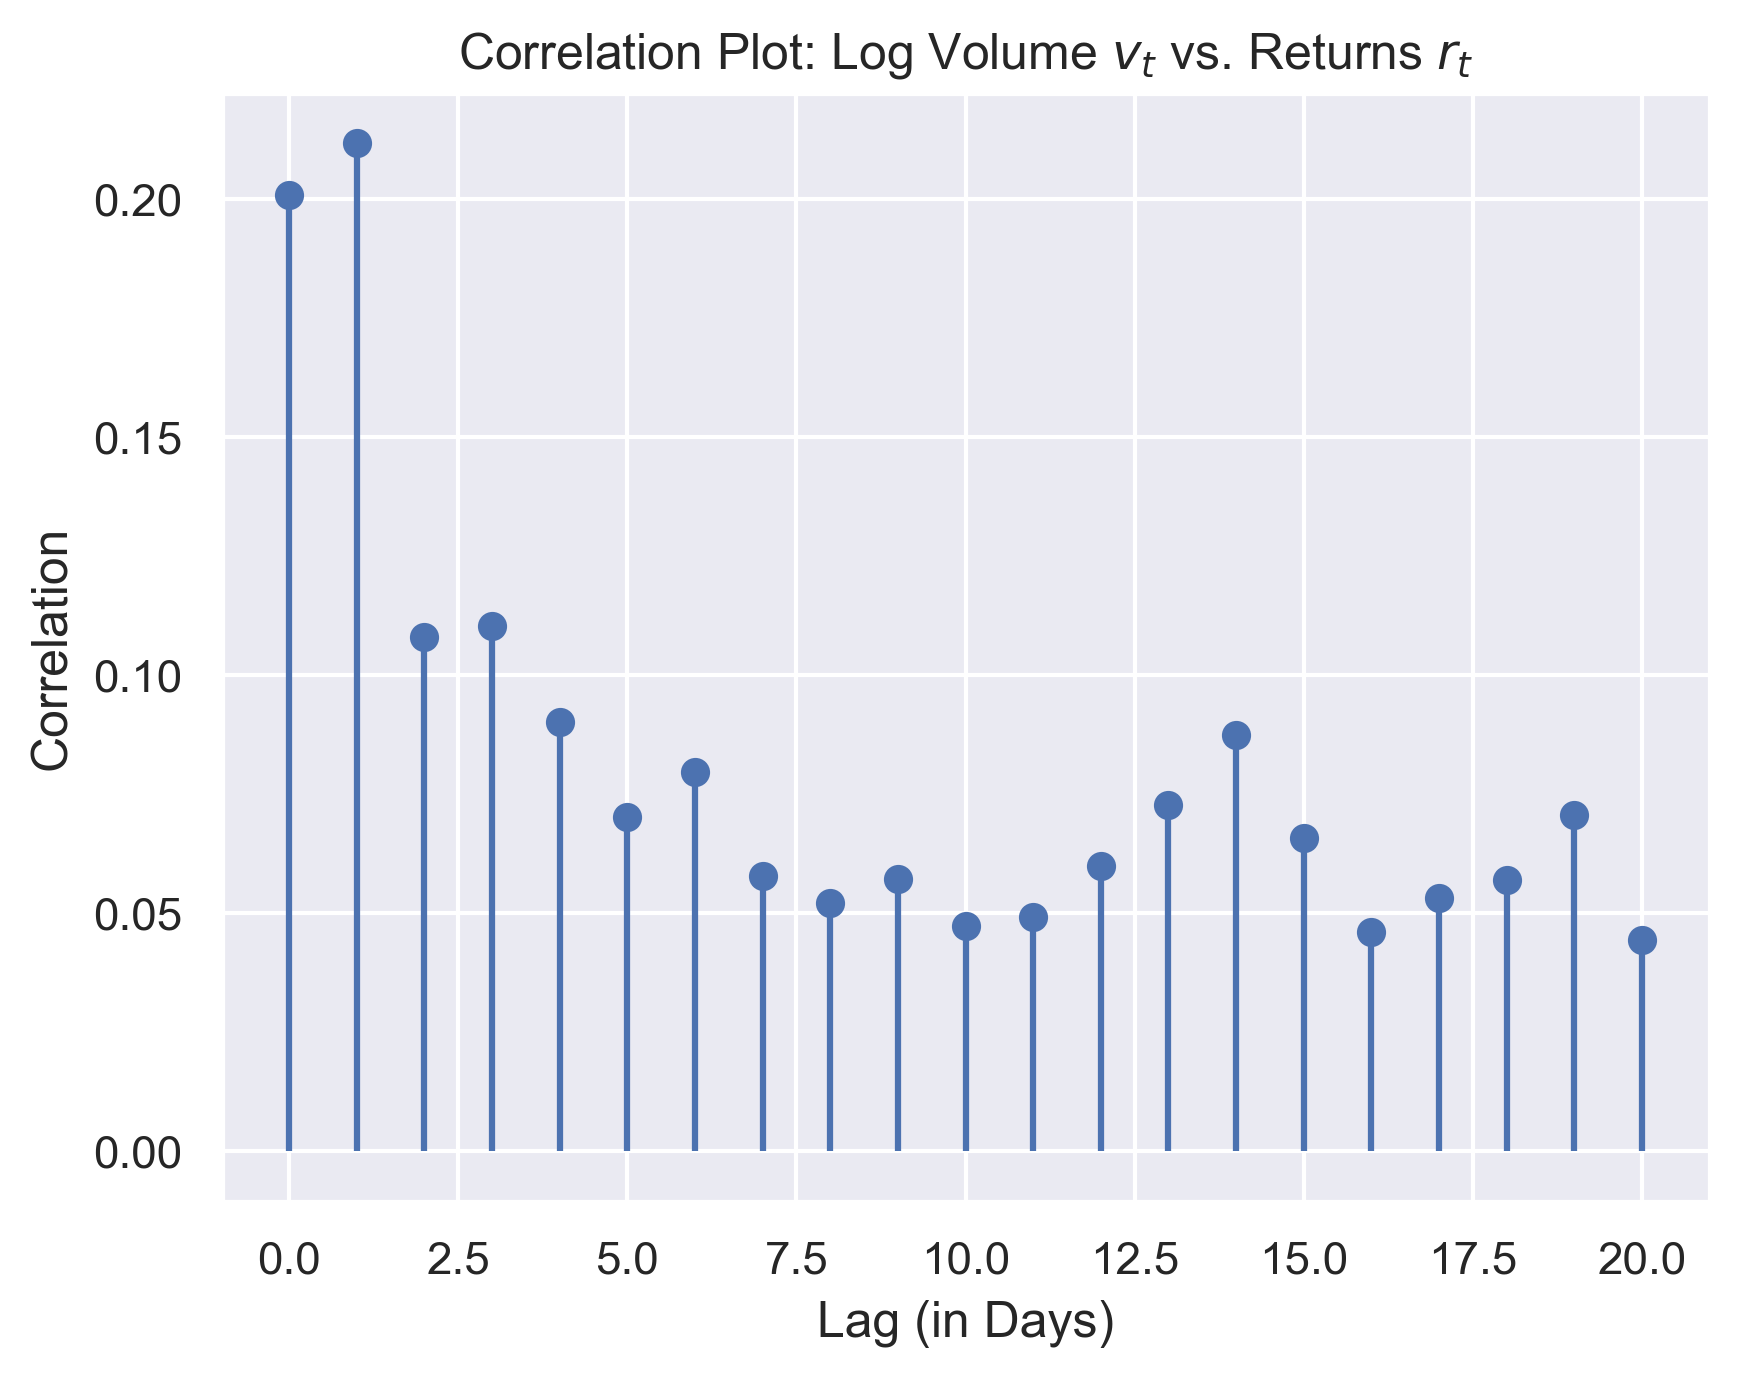

In [4]:
# Log Volume vs. DJ Return (+ lags)
lags = range(0,21)
corrs_vtrt = [NYSE['log_volume'].corr(
    NYSE['DJ_return'].shift(lag)) for lag in lags]
plt.figure()
plt.scatter(lags, corrs_vtrt)
plt.vlines(lags, ymin=0, ymax=corrs_vtrt)
plt.title('Correlation Plot: Log Volume $v_t$ vs. Returns $r_t$')
plt.xlabel('Lag (in Days)')
plt.ylabel('Correlation')
plt.show()

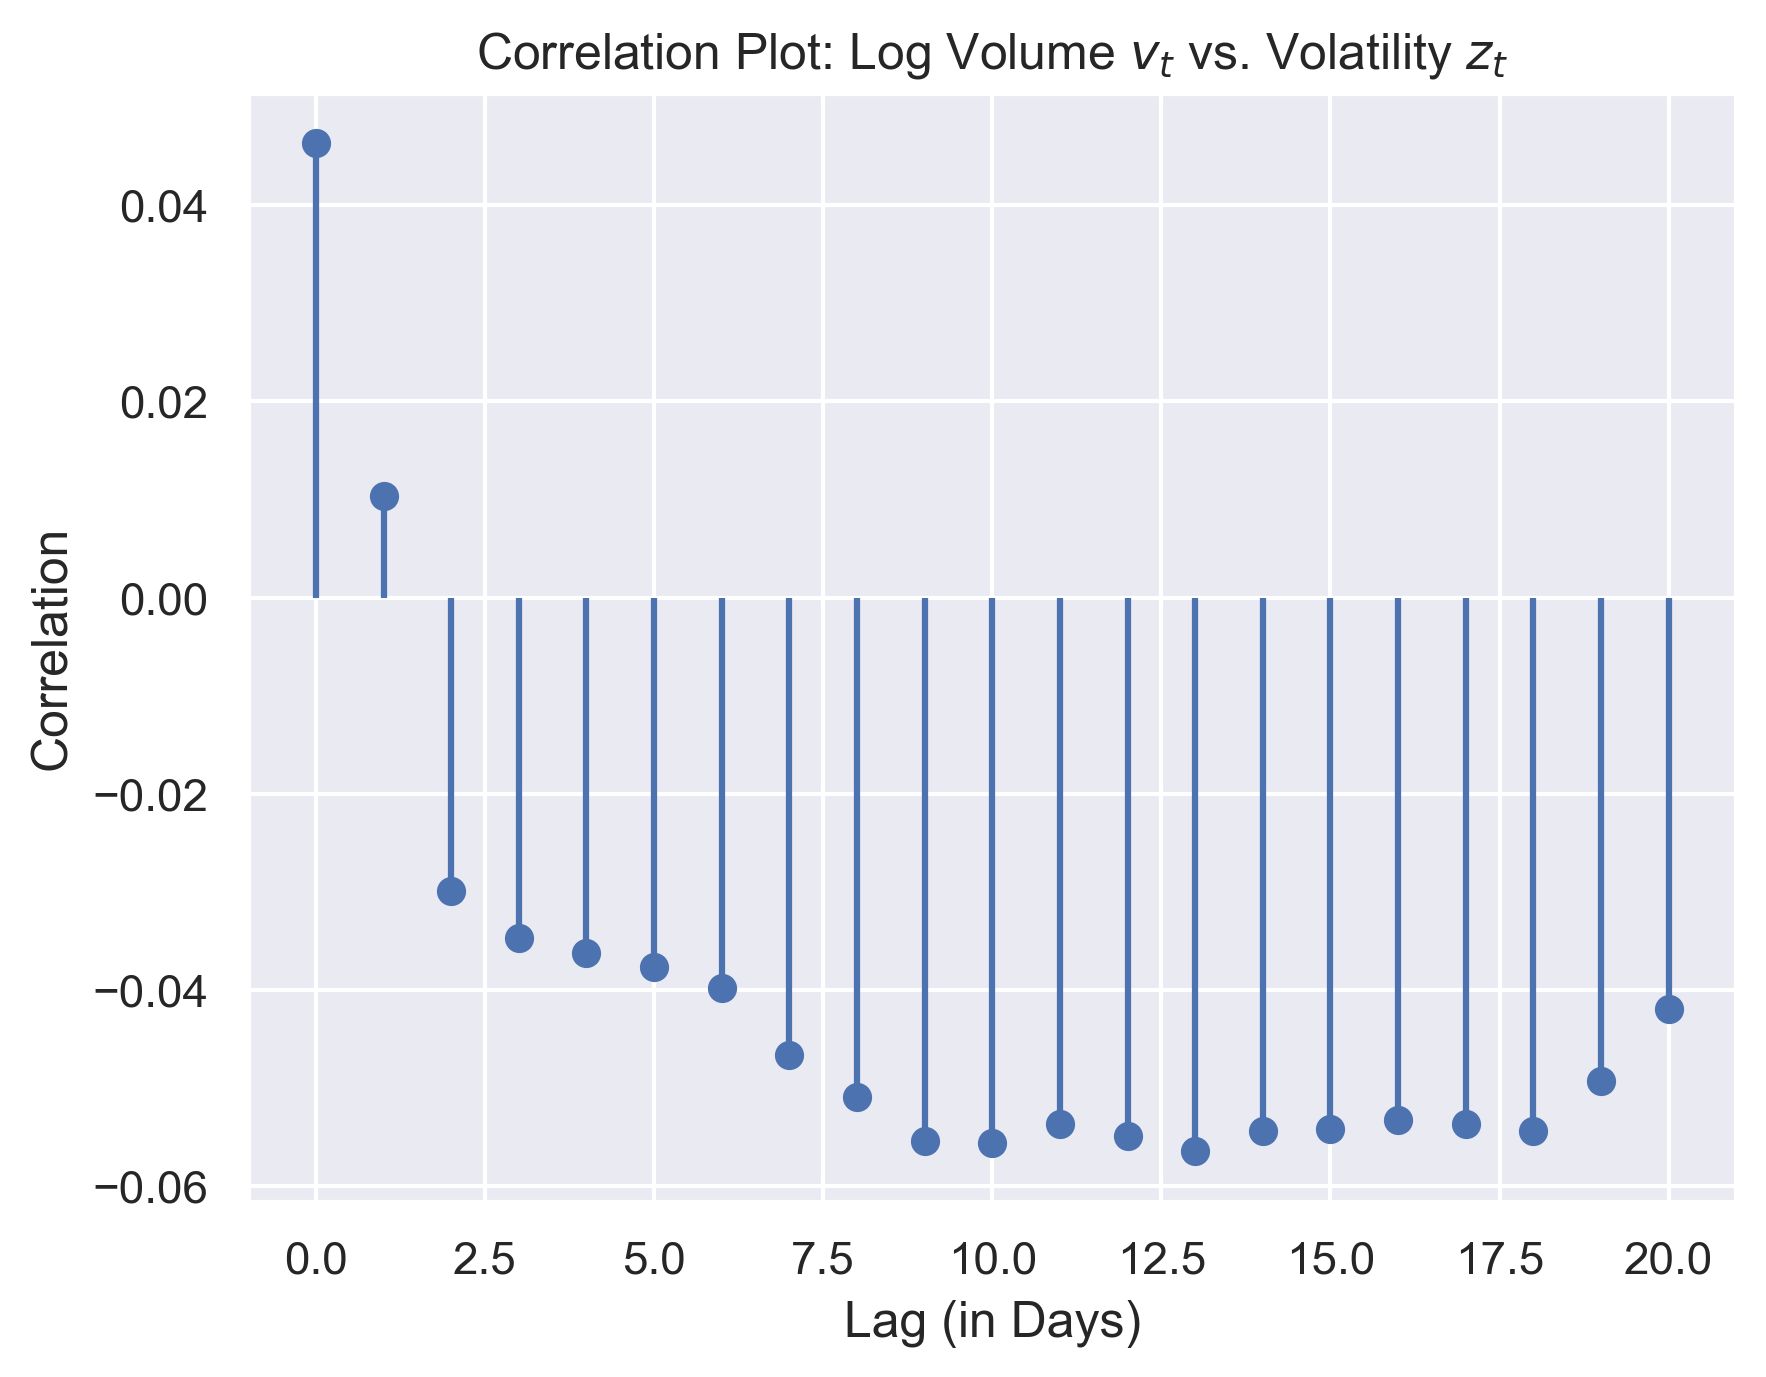

In [5]:
# Log Volume vs. Log Volatility (+ lags)
lags = range(0,21)
corrs_vtzt = [NYSE['log_volume'].corr(
    NYSE['log_volatility'].shift(lag)) for lag in lags]
plt.figure()
plt.scatter(lags, corrs_vtzt)
plt.vlines(lags, ymin=0, ymax=corrs_vtzt)
plt.title('Correlation Plot: Log Volume $v_t$ vs. Volatility $z_t$')
plt.xlabel('Lag (in Days)')
plt.ylabel('Correlation')
plt.show()

Above are the correlation plots. For $v_t$ against its own lags, we see fairly strong correlation for the first couple days and then it tapers out. This implies that we may be able to get useful predictions out of lagged log volume.

Similarly, but to a lesser degree, returns seem to be weakly correlated with log volume within a couple days before tapering out. And lastly, log volume and log volatility seem to be barely correlated. Despite the correlation flipping from positive to negative, all values are less than 0.06 in absolute value.

In [84]:
# Quick Statistical Summary
NYSE.describe()

,DJ_return,log_volume,log_volatility
count,6051.000000,6051.000000,6051.000000
mean,0.000177,-0.008336,-9.842713
std,0.008436,0.233684,0.753937
min,-0.047177,-1.322425,-13.127403
25%,-0.004640,-0.159956,-10.334196
50%,0.000125,-0.013249,-9.843592
75%,0.004792,0.131632,-9.379632
max,0.049517,1.039370,-7.477833


## Project Goal

Our goal is to forecast daily `Log trading volume`, using various machine learning algorithms.

The data set is already split into train (before Jan 1st, 1980, $n_{\text{train}} = 4,281$) and test (after Jan 1st, 1980, $n_{\text{test}} = 1,770$) sets.

In general, we would tune the lag $L$ to acheive best forecasting performance. In this project, we will fix $L=5$. That is, we always use the previous five trading days' data to forecast today's `log trading volume`.

We will pay attention to the nuance of splitting time series data for cross validation. Namely, we use [`TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) in Scikit-Learn. Additionally, we make sure to use the same splits when tuning different machine learning algorithms.

Additionally, a sensible metric for most prediction problems would MSE. However, for grading purposes, we will use the $R^2$ between forecast and actual values as the cross validation and test evaluation criterion.

### Data Pre-Processing

Firstly, we focus on pre-processing our data. Namely, we create a new data frame with new features that correspond to lagged iterations of our primary 3 variables.

In [6]:
# New Data Frame with Lags
df = pd.DataFrame({
    'log_volume': NYSE['log_volume'],
    'log_volume_l1': NYSE['log_volume'].shift(1),
    'log_volume_l2': NYSE['log_volume'].shift(2),
    'log_volume_l3': NYSE['log_volume'].shift(3),
    'log_volume_l4': NYSE['log_volume'].shift(4),
    'log_volume_l5': NYSE['log_volume'].shift(5),
    'DJ_return': NYSE['DJ_return'],
    'DJ_return_l1': NYSE['DJ_return'].shift(1),
    'DJ_return_l2': NYSE['DJ_return'].shift(2),
    'DJ_return_l3': NYSE['DJ_return'].shift(3),
    'DJ_return_l4': NYSE['DJ_return'].shift(4),
    'DJ_return_l5': NYSE['DJ_return'].shift(5),
    'log_volatility': NYSE['log_volatility'],
    'log_volatility_l1': NYSE['log_volatility'].shift(1),
    'log_volatility_l2': NYSE['log_volatility'].shift(2),
    'log_volatility_l3': NYSE['log_volatility'].shift(3),
    'log_volatility_l4': NYSE['log_volatility'].shift(4),
    'log_volatility_l5': NYSE['log_volatility'].shift(5),
    'train': NYSE['train']
})

In [7]:
df.head(10)

,log_volume,log_volume_l1,log_volume_l2,log_volume_l3,log_volume_l4,log_volume_l5,DJ_return,DJ_return_l1,DJ_return_l2,DJ_return_l3,DJ_return_l4,DJ_return_l5,log_volatility,log_volatility_l1,log_volatility_l2,log_volatility_l3,log_volatility_l4,log_volatility_l5,train
date,,,,,,,,,,,,,,,,,,,
1962-12-03,0.032573,NaN,NaN,NaN,NaN,NaN,-0.004461,NaN,NaN,NaN,NaN,NaN,-13.127403,NaN,NaN,NaN,NaN,NaN,True
1962-12-04,0.346202,0.032573,NaN,NaN,NaN,NaN,0.007813,-0.004461,NaN,NaN,NaN,NaN,-11.749305,-13.127403,NaN,NaN,NaN,NaN,True
1962-12-05,0.525306,0.346202,0.032573,NaN,NaN,NaN,0.003845,0.007813,-0.004461,NaN,NaN,NaN,-11.665609,-11.749305,-13.127403,NaN,NaN,NaN,True
1962-12-06,0.210182,0.525306,0.346202,0.032573,NaN,NaN,-0.003462,0.003845,0.007813,-0.004461,NaN,NaN,-11.626772,-11.665609,-11.749305,-13.127403,NaN,NaN,True
1962-12-07,0.044187,0.210182,0.525306,0.346202,0.032573,NaN,0.000568,-0.003462,0.003845,0.007813,-0.004461,NaN,-11.728130,-11.626772,-11.665609,-11.749305,-13.127403,NaN,True
1962-12-10,0.133246,0.044187,0.210182,0.525306,0.346202,0.032573,-0.010824,0.000568,-0.003462,0.003845,0.007813,-0.004461,-10.872526,-11.728130,-11.626772,-11.665609,-11.749305,-13.127403,True
1962-12-11,-0.011528,0.133246,0.044187,0.210182,0.525306,0.346202,0.000124,-0.010824,0.000568,-0.003462,0.003845,0.007813,-10.977797,-10.872526,-11.728130,-11.626772,-11.665609,-11.749305,True
1962-12-12,0.001607,-0.011528,0.133246,0.044187,0.210182,0.525306,0.003358,0.000124,-0.010824,0.000568,-0.003462,0.003845,-11.012360,-10.977797,-10.872526,-11.728130,-11.626772,-11.665609,True
1962-12-13,-0.106437,0.001607,-0.011528,0.133246,0.044187,0.210182,-0.003296,0.003358,0.000124,-0.010824,0.000568,-0.003462,-11.047108,-11.012360,-10.977797,-10.872526,-11.728130,-11.626772,True


We now drop the 5 rows with NAs. Then we split via the training indicator. And lastly, we will split our train / test data frames into feature and target variables.

In [8]:
# Drop NA values that arise from lag
df1 = df.dropna()
print('Data Shape: ', df1.shape)

Data Shape:  (6046, 19)


In [9]:
# Train-test split
train = df1[df1['train'] == True]
test = df1[df1['train'] == False]

In [10]:
# Shape matches specification (minus lag drops)
print('Training data shape:', train.shape)
print('Testing data shape:', test.shape)

Training data shape: (4276, 19)
Testing data shape: (1770, 19)


In [11]:
# Feature split
X_train = train.drop(columns=['log_volume', 'DJ_return',
                               'log_volatility', 'train'], axis=1)
X_test = test.drop(columns=['log_volume', 'DJ_return',
                               'log_volatility', 'train'], axis=1)
y_train = train.log_volume
y_test = test.log_volume

In [12]:
print('Training X shape:', X_train.shape)
print('Testing X shape:', X_test.shape)
print('Training y shape:', y_train.shape)
print('Testing y shape:', y_test.shape)

Training X shape: (4276, 15)
Testing X shape: (1770, 15)
Training y shape: (4276,)
Testing y shape: (1770,)


Notice that we drop the current period version of our features. This is because we are trying to forecast future log volatility. In a testing environment, we would not have access to future values for the DJ return and log volatility. Hence, we only regress on the lagged variables. Therefore, our models will all have 15 features.

In [13]:
X_train

,log_volume_l1,log_volume_l2,log_volume_l3,log_volume_l4,log_volume_l5,DJ_return_l1,DJ_return_l2,DJ_return_l3,DJ_return_l4,DJ_return_l5,log_volatility_l1,log_volatility_l2,log_volatility_l3,log_volatility_l4,log_volatility_l5
date,,,,,,,,,,,,,,,
1962-12-10,0.044187,0.210182,0.525306,0.346202,0.032573,0.000568,-0.003462,0.003845,0.007813,-0.004461,-11.728130,-11.626772,-11.665609,-11.749305,-13.127403
1962-12-11,0.133246,0.044187,0.210182,0.525306,0.346202,-0.010824,0.000568,-0.003462,0.003845,0.007813,-10.872526,-11.728130,-11.626772,-11.665609,-11.749305
1962-12-12,-0.011528,0.133246,0.044187,0.210182,0.525306,0.000124,-0.010824,0.000568,-0.003462,0.003845,-10.977797,-10.872526,-11.728130,-11.626772,-11.665609
1962-12-13,0.001607,-0.011528,0.133246,0.044187,0.210182,0.003358,0.000124,-0.010824,0.000568,-0.003462,-11.012360,-10.977797,-10.872526,-11.728130,-11.626772
1962-12-14,-0.106437,0.001607,-0.011528,0.133246,0.044187,-0.003296,0.003358,0.000124,-0.010824,0.000568,-11.047108,-11.012360,-10.977797,-10.872526,-11.728130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1979-12-24,-0.001507,0.108579,0.144112,0.183537,0.199621,-0.005267,0.005267,0.000310,-0.007093,0.002216,-10.280234,-10.259191,-10.236318,-10.131226,-10.160962
1979-12-26,-0.631830,-0.001507,0.108579,0.144112,0.183537,0.000298,-0.005267,0.005267,0.000310,-0.007093,-10.385307,-10.280234,-10.259191,-10.236318,-10.131226
1979-12-27,-0.365829,-0.631830,-0.001507,0.108579,0.144112,-0.001216,0.000298,-0.005267,0.005267,0.000310,-10.485360,-10.385307,-10.280234,-10.259191,-10.236318


## Baseline Method (20 pts)

We use the straw man (use yesterday’s value of `log trading volume` to predict that of today) as the baseline method. Then we evaluate the $R^2$ of this method on the test data.

In [14]:
# Strawman Method
## Prediction for tomorrow is just today
strawman_y_actual = y_test[1:]
strawman_y_pred = y_test[:-1]
r2_strawman = r2_score(
    strawman_y_actual,
    strawman_y_pred
)
print('R2 score (Strawman): ', r2_strawman)

R2 score (Strawman):  0.18073700785807378


This simple method gets us a $R^2$ of about 0.18. Obviously, there is no cross-validation in this method since there is nothing to tune. Therefore, we only report testing $R^2$. This metric will serve as our baseline which we hope to beat with our machine learning models.

## Autoregression (AR) forecaster (30 pts)

- Let
$$
y = \begin{pmatrix} v_{L+1} \\ v_{L+2} \\ v_{L+3} \\ \vdots \\ v_T \end{pmatrix}, \quad M = \begin{pmatrix}
1 & v_L & v_{L-1} & \cdots & v_1 \\
1 & v_{L+1} & v_{L} & \cdots & v_2 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & v_{T-1} & v_{T-2} & \cdots & v_{T-L}
\end{pmatrix}.
$$

- We will fit an ordinary least squares (OLS) regression of $y$ on $M$, giving
$$
\hat v_t = \hat \beta_0 + \hat \beta_1 v_{t-1} + \hat \beta_2 v_{t-2} + \cdots + \hat \beta_L v_{t-L},
$$
known as an **order-$L$ autoregression** model or **AR($L$)**.

- Then we will tune AR(5) with elastic net (lasso + ridge) regularization using all 3 features on the training data, and evaluate the test performance. 

We begin by standardizing our features so that our regularization process isn't biased.

In [15]:
# Standardization Transformer
scalar = StandardScaler()

# Model
elasticnet = ElasticNet(
    #max_iter = 10000,
    random_state = 425
)

# Pipeline
pipe_en = Pipeline(steps=[
    ('scalar', scalar),
    ('model', elasticnet)
])
pipe_en

Pipeline(steps=[('scalar', StandardScaler()),
                ('model', ElasticNet(random_state=425))])

We will tune the regularization strength for Elastic Net. This will involve tuning 2 parameters. We consider 15 equally spaced values for each parameter to see what is optimal.

In [16]:
# Hyper-parameter Tuning
alphas = np.linspace(0.0001, 1, 15)
l1_ratios = np.linspace(0.0001, 0.9, 15)
tuned_params = {
    "model__alpha": alphas,
    "model__l1_ratio": l1_ratios
}

In [17]:
# Time Series Split
tscv = TimeSeriesSplit(n_splits=5)

# Cross Validation
search_en = GridSearchCV(
    pipe_en,
    tuned_params,
    cv = tscv, # Time Series Split
    scoring = "r2",
    refit = True
)

In [18]:
# Fit CV
search_en.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('model',
                                        ElasticNet(random_state=425))]),
             param_grid={'model__alpha': array([1.00000000e-04, 7.15214286e-02, 1.42942857e-01, 2.14364286e-01,
       2.85785714e-01, 3.57207143e-01, 4.28628571e-01, 5.00050000e-01,
       5.71471429e-01, 6...57e-01, 7.14314286e-01, 7.85735714e-01,
       8.57157143e-01, 9.28578571e-01, 1.00000000e+00]),
                         'model__l1_ratio': array([1.00000000e-04, 6.43785714e-02, 1.28657143e-01, 1.92935714e-01,
       2.57214286e-01, 3.21492857e-01, 3.85771429e-01, 4.50050000e-01,
       5.14328571e-01, 5.78607143e-01, 6.42885714e-01, 7.07164286e-01,
       7.71442857e-01, 8.35721429e-01, 9.00000000e-01])},
             scoring='r2')

<Figure size 1920x1440 with 0 Axes>

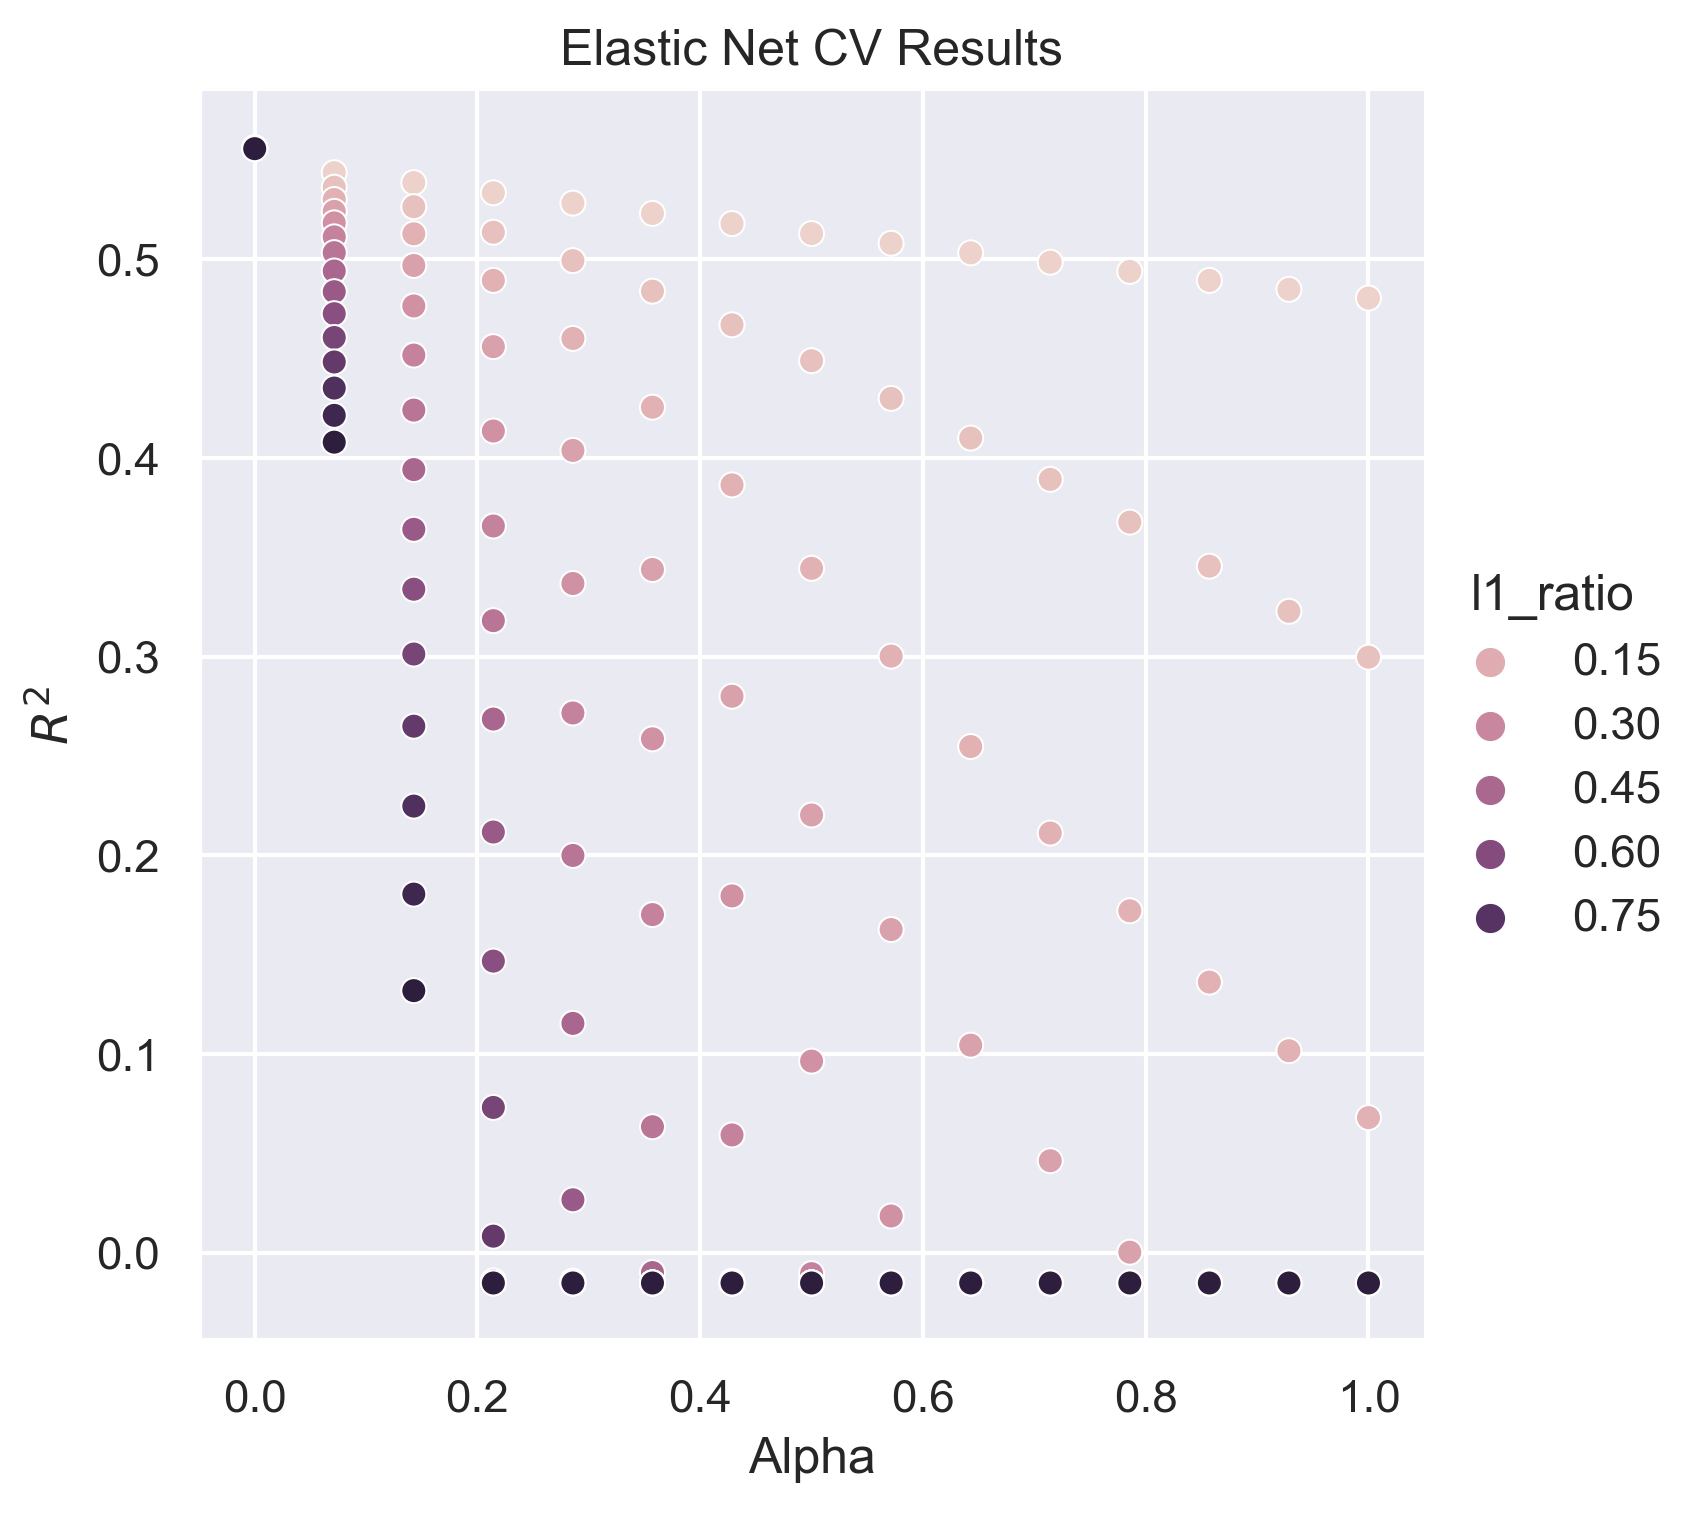

Best CV R2 Score:  0.5562329203092148


In [19]:
# CV Visualization
cv_res_en = pd.DataFrame({
    "alpha": np.array(search_en.cv_results_["param_model__alpha"]),
    "l1_ratio": np.array(search_en.cv_results_["param_model__l1_ratio"]),
    "r2": search_en.cv_results_["mean_test_score"]
})

plt.figure()
sns.relplot(
    data = cv_res_en,
    x = "alpha",
    y = "r2",
    hue = "l1_ratio"
).set(
    xlabel = "Alpha",
    ylabel = "$R^2$",
    title = "Elastic Net CV Results"
)
plt.show()
cv_r2_en = search_en.best_score_
print('Best CV R2 Score: ', search_en.best_score_)

After testing implementing multiple grid searches, it is clear that our elastic net model performs best when both of its regularization parameters are as close to 0 as possible. This implies that a simple Auto Regressive model is best here, and regularization does not add much value. The implication here is that all of our features are significant enough to be included.

In [20]:
# Finalize Model
search_en.best_estimator_

Pipeline(steps=[('scalar', StandardScaler()),
                ('model',
                 ElasticNet(alpha=0.0001, l1_ratio=0.0001, random_state=425))])

In [21]:
# Final Testing R^2
en_r2 = r2_score(
    y_test,
    search_en.best_estimator_.predict(X_test))
print('Elastic Net R2: ', en_r2)

Elastic Net R2:  0.41290503280129076


We finalize this AR(5) model and report an $R^2$ of about 0.41 which is substantially better than our strawman model.

## Autoregression by MLP (30 pts)

We will now consider a simple Neural Network using our same set of predictors. Namely, this will act as a sort of auto regressive neural net. Once again, we standardize our variables, then will initialize a version of our model.

In [22]:
# Standardization Transformer
scalar = StandardScaler()

# Model
mlp_mod = MLPRegressor(
    hidden_layer_sizes = (1,),
    activation = 'relu',
    solver = 'adam',
    batch_size = 16,
    random_state = 425
)

# Pipeline
pipe_mlp = Pipeline(steps=[
    ('scalar', scalar),
    ('model', mlp_mod)
])
pipe_mlp

Pipeline(steps=[('scalar', StandardScaler()),
                ('model',
                 MLPRegressor(batch_size=16, hidden_layer_sizes=(1,),
                              random_state=425))])

As far as hyper-parameter tuning goes, we focus on tuning the hidden layer sizes and quantities and the batch sizes. One could also tune activiation functions and solvers; however, we expect that relu and adam will be sufficient for our purposes.

In [23]:
# Hyper-parameter Tuning
hls_grid = [(1,), (10,), (20,5,), (10,10,),
            (5,5,5,), (10,10,10,)]
bs_grid = [4, 8, 12, 16, 20, 24, 28, 32]
tuned_params = {
    "model__hidden_layer_sizes": hls_grid,
    "model__batch_size": bs_grid
}

In [24]:
# Time Series Split
tscv = TimeSeriesSplit(n_splits=5)

# Cross Validation
search_mlp = GridSearchCV(
    pipe_mlp,
    tuned_params,
    cv = tscv, # Time Series Split
    scoring = "r2",
    refit = True
)

In [25]:
# Fit CV
search_mlp.fit(X_test, y_test)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('model',
                                        MLPRegressor(batch_size=16,
                                                     hidden_layer_sizes=(1,),
                                                     random_state=425))]),
             param_grid={'model__batch_size': [4, 8, 12, 16, 20, 24, 28, 32],
                         'model__hidden_layer_sizes': [(1,), (10,), (20, 5),
                                                       (10, 10), (5, 5, 5),
                                                       (10, 10, 10)]},
             scoring='r2')

<Figure size 1920x1440 with 0 Axes>

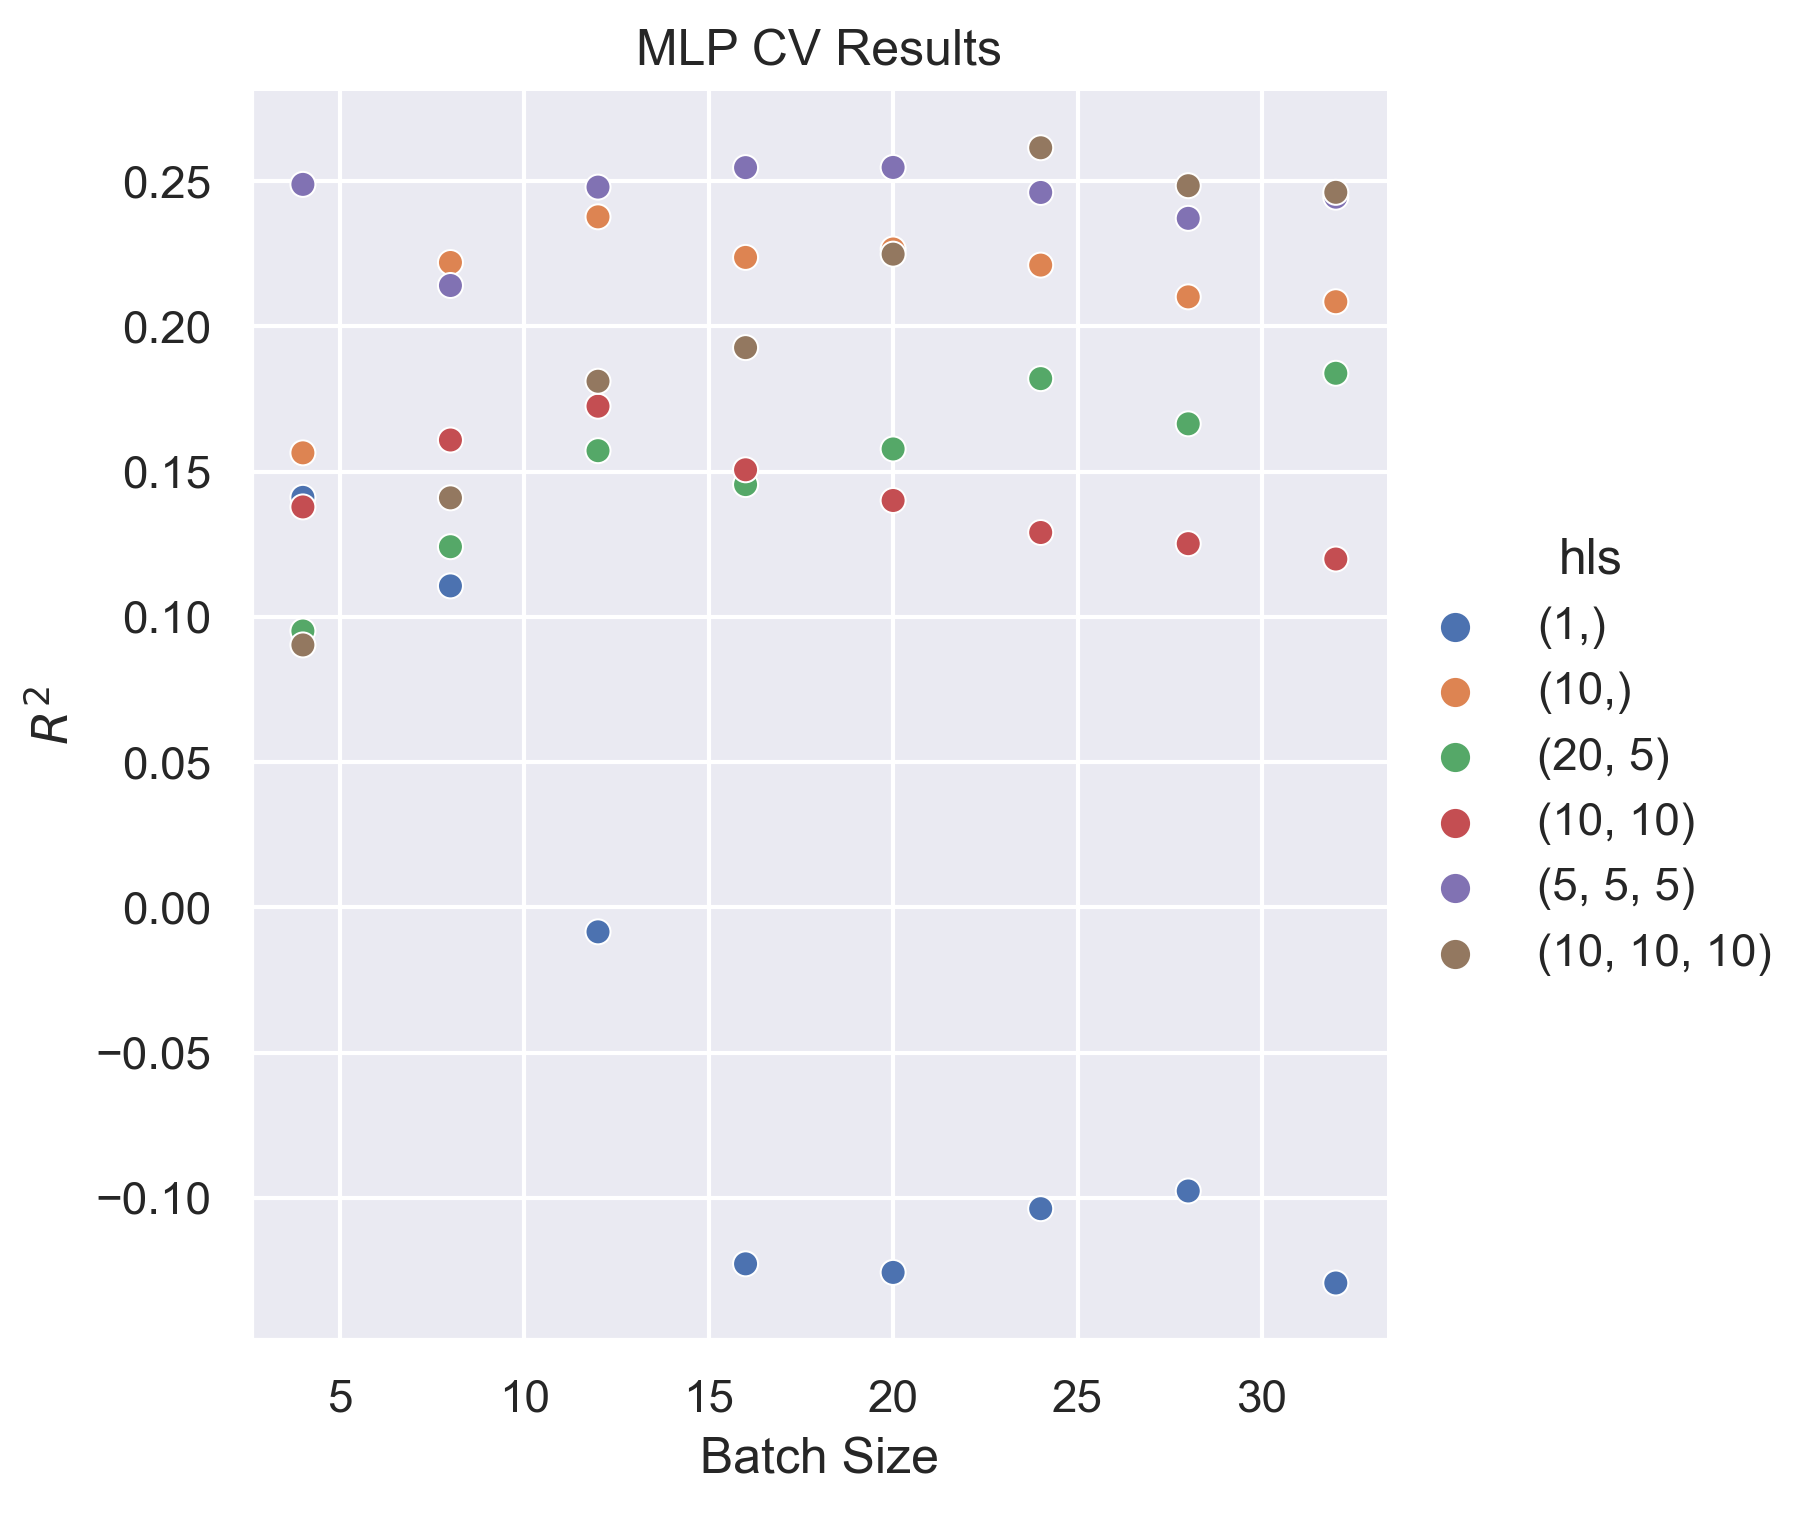

Best CV R2 Score:  0.2615247042852141


In [26]:
# CV Visualization
cv_res_mlp = pd.DataFrame({
  "bs": np.array(search_mlp.cv_results_["param_model__batch_size"]),
  "r2": search_mlp.cv_results_["mean_test_score"],
  "hls": search_mlp.cv_results_["param_model__hidden_layer_sizes"]
  })

plt.figure()
sns.relplot(
  # kind = "line",
  data = cv_res_mlp,
  x = "bs",
  y = "r2",
  hue = "hls"
).set(
    xlabel = "Batch Size",
    ylabel = "$R^2$",
    title = "MLP CV Results")
plt.show()
cv_r2_mlp = search_mlp.best_score_
print('Best CV R2 Score: ', cv_r2_mlp)

The cross validation procedure results in a final model that has 3 hidden layers with 10 neurons in each layer. Additionally, the optimal batch size was found to be 24. With these hyper-parameters, we finalize model and test on the testing set.

In [27]:
# Finalize Model
search_mlp.best_estimator_

Pipeline(steps=[('scalar', StandardScaler()),
                ('model',
                 MLPRegressor(batch_size=24, hidden_layer_sizes=(10, 10, 10),
                              random_state=425))])

In [28]:
# Final Testing R^2
mlp_r2 = r2_score(
    y_test,
    search_mlp.best_estimator_.predict(X_test))
print('MLP R2: ', mlp_r2)

MLP R2:  0.4983900979507502


With our finalized model, we get an $R^2$ of about 0.498 which is very good all things considered. It out performs the simple AR(5) model and strawman. We even get better performance here than any of our other models soon to be shown.

## LSTM forecaster (30 pts)

- We extract many short mini-series of input sequences $X=\{X_1,X_2,\ldots,X_L\}$ with a predefined lag $L$:
$$
X_1 = \begin{pmatrix} v_{t-L} \\ r_{t-L} \\ z_{t-L} \end{pmatrix}, \ 
X_2 = \begin{pmatrix} v_{t-L+1} \\ r_{t-L+1} \\ z_{t-L+1} \end{pmatrix}, \ 
\cdots, \ 
X_L = \begin{pmatrix} v_{t-1} \\ r_{t-1} \\ z_{t-1} \end{pmatrix}, 
$$
and
$$Y = v_t $$

Note, we will not be cross-validating (as per the Professor's recommendation) since gridsearch is very computationally demanding on an LSTM model. Therefore, we will proceed and tune the LSTM model by hand and try to get the best performance using sensible values for batch size, epochs, layers, etc.

### LSTM Pre-Processing

When using `tensorflow` we need to be careful with how we pre-process our data. Namely, the technique of having lagged columns in our dataframe would not work here. Hence, we will pre-process our data again using a different technique. We define a function `create_dataset` which takes in our data, initializes tensors, then appends lagged iterations of our data into the tensors in a format that works well with `keras`.

In [61]:
# RNN DATA PRE-PROCESSING
df_rnn = NYSE.drop(columns = 'day_of_week')

## Train-test split
train_rnn = df_rnn[df_rnn['train'] == True]
test_rnn = df_rnn[df_rnn['train'] == False]

## Feature split
X_train_rnn = train_rnn.drop(columns=['train'], axis=1)
X_test_rnn = test_rnn.drop(columns=['train'], axis=1)
y_train_rnn = train_rnn.log_volume
y_test_rnn = test_rnn.log_volume

## Define input sequence length (number of lags)
seq_length = 5

## Define number of features
num_features = 3

## Define train and test sets for LSTM model
def create_dataset(X, y, seq_length):
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(X.iloc[i:(i+seq_length), :].values)
        ys.append(y.iloc[i+seq_length])
    return np.array(Xs), np.array(ys)

In [81]:
## DATA FOR LSTM
train_X, train_y = create_dataset(X_train_rnn, y_train_rnn, seq_length)
test_X, test_y = create_dataset(X_test_rnn, y_test_rnn, seq_length)

## Data Shape Looks Right
print('Training X Shape: ', train_X.shape)
print('Testing X Shape: ', test_X.shape)
print('Training y Shape: ', train_y.shape)
print('Testing y Shape: ', test_y.shape)

Training X Shape:  (4276, 5, 3)
Testing X Shape:  (1765, 5, 3)
Training y Shape:  (4276,)
Testing y Shape:  (1765,)


Take note of the shape of our `X` variables. 5 represents the number of lags and 3 represents the number of features. Furthermore, Since `Keras` does not have $R^2$ as a built-in metric, we will define it ourselves. To do this, we call on a `keras` wrapper and manually define $R^2$ using sum of squared residuals and totaal sum of squares.

In [63]:
# Define R^2 as metric
def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res/(SS_tot + K.epsilon()))

Below, we present our LSTM model using `tensorflow` and `keras`. Note that we consider a very simple LSTM model and use our defined $R^2$ as the metric of evaluation.

In [72]:
# Define model architecture
rnn = Sequential()
rnn.add(LSTM(64, input_shape=(seq_length, num_features)))
rnn.add(Dense(1))

# Compile model
rnn.compile(optimizer='adam',
             loss='mse', metrics=[r_squared])

In [77]:
# Train model
rnn.fit(train_X, train_y, epochs=30,
         batch_size=32, validation_split=0.1,
         verbose=0)

In [78]:
# Make Predictions
rnn_preds = rnn.predict(test_X)

56/56 [==============================] - 0s 3ms/step


In [79]:
# Final Testing R2
lstm_r2 = r2_score(
    test_y,
    rnn_preds)
print('LSTM Test R2: ', lstm_r2)

LSTM Test R2:  0.4102404270052674


After manually tuning our LSTM model, we find that this very simple architecture provided the best performance. We experimented with additional LSTM layers and dropout; however, both actually substantially worsened performance. The implication here being that a simple model is sometimes better than a complex one. The testing $R^2$ here was about 0.41 which is inline with our other methods.

## Random forest forecaster (30pts)

We use the same features as in AR($L$) for the random forest. We tune the random forest and evaluate the test performance.

In [30]:
# Model
randomforest = RandomForestRegressor(
    n_estimators = 100,
    criterion = 'squared_error',
    max_features = 'sqrt',
    oob_score = True,
    random_state = 425
)

# Pipeline
pipe_rf = Pipeline(steps = [
    ("model", randomforest)
])
pipe_rf

Pipeline(steps=[('model',
                 RandomForestRegressor(max_features='sqrt', oob_score=True,
                                       random_state=425))])

Namely, we will tune the amount of trees that get produced and the optimal max feature count.

In [31]:
# Hyper-parameter Tuning
B_grid = [50, 100, 150, 200, 250, 300]
m_grid = ['sqrt', 'log2', 1.0]
tuned_params = {
    "model__n_estimators": B_grid,
    "model__max_features": m_grid
}

In [32]:
# Time Series Split
tscv = TimeSeriesSplit(n_splits=5)

# Cross Validation
search_rf = GridSearchCV(
    pipe_rf,
    tuned_params,
    cv = tscv,
    scoring = "r2",
    refit = True
)

In [33]:
# Fit CV
search_rf.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('model',
                                        RandomForestRegressor(max_features='sqrt',
                                                              oob_score=True,
                                                              random_state=425))]),
             param_grid={'model__max_features': ['sqrt', 'log2', 1.0],
                         'model__n_estimators': [50, 100, 150, 200, 250, 300]},
             scoring='r2')

<Figure size 1920x1440 with 0 Axes>

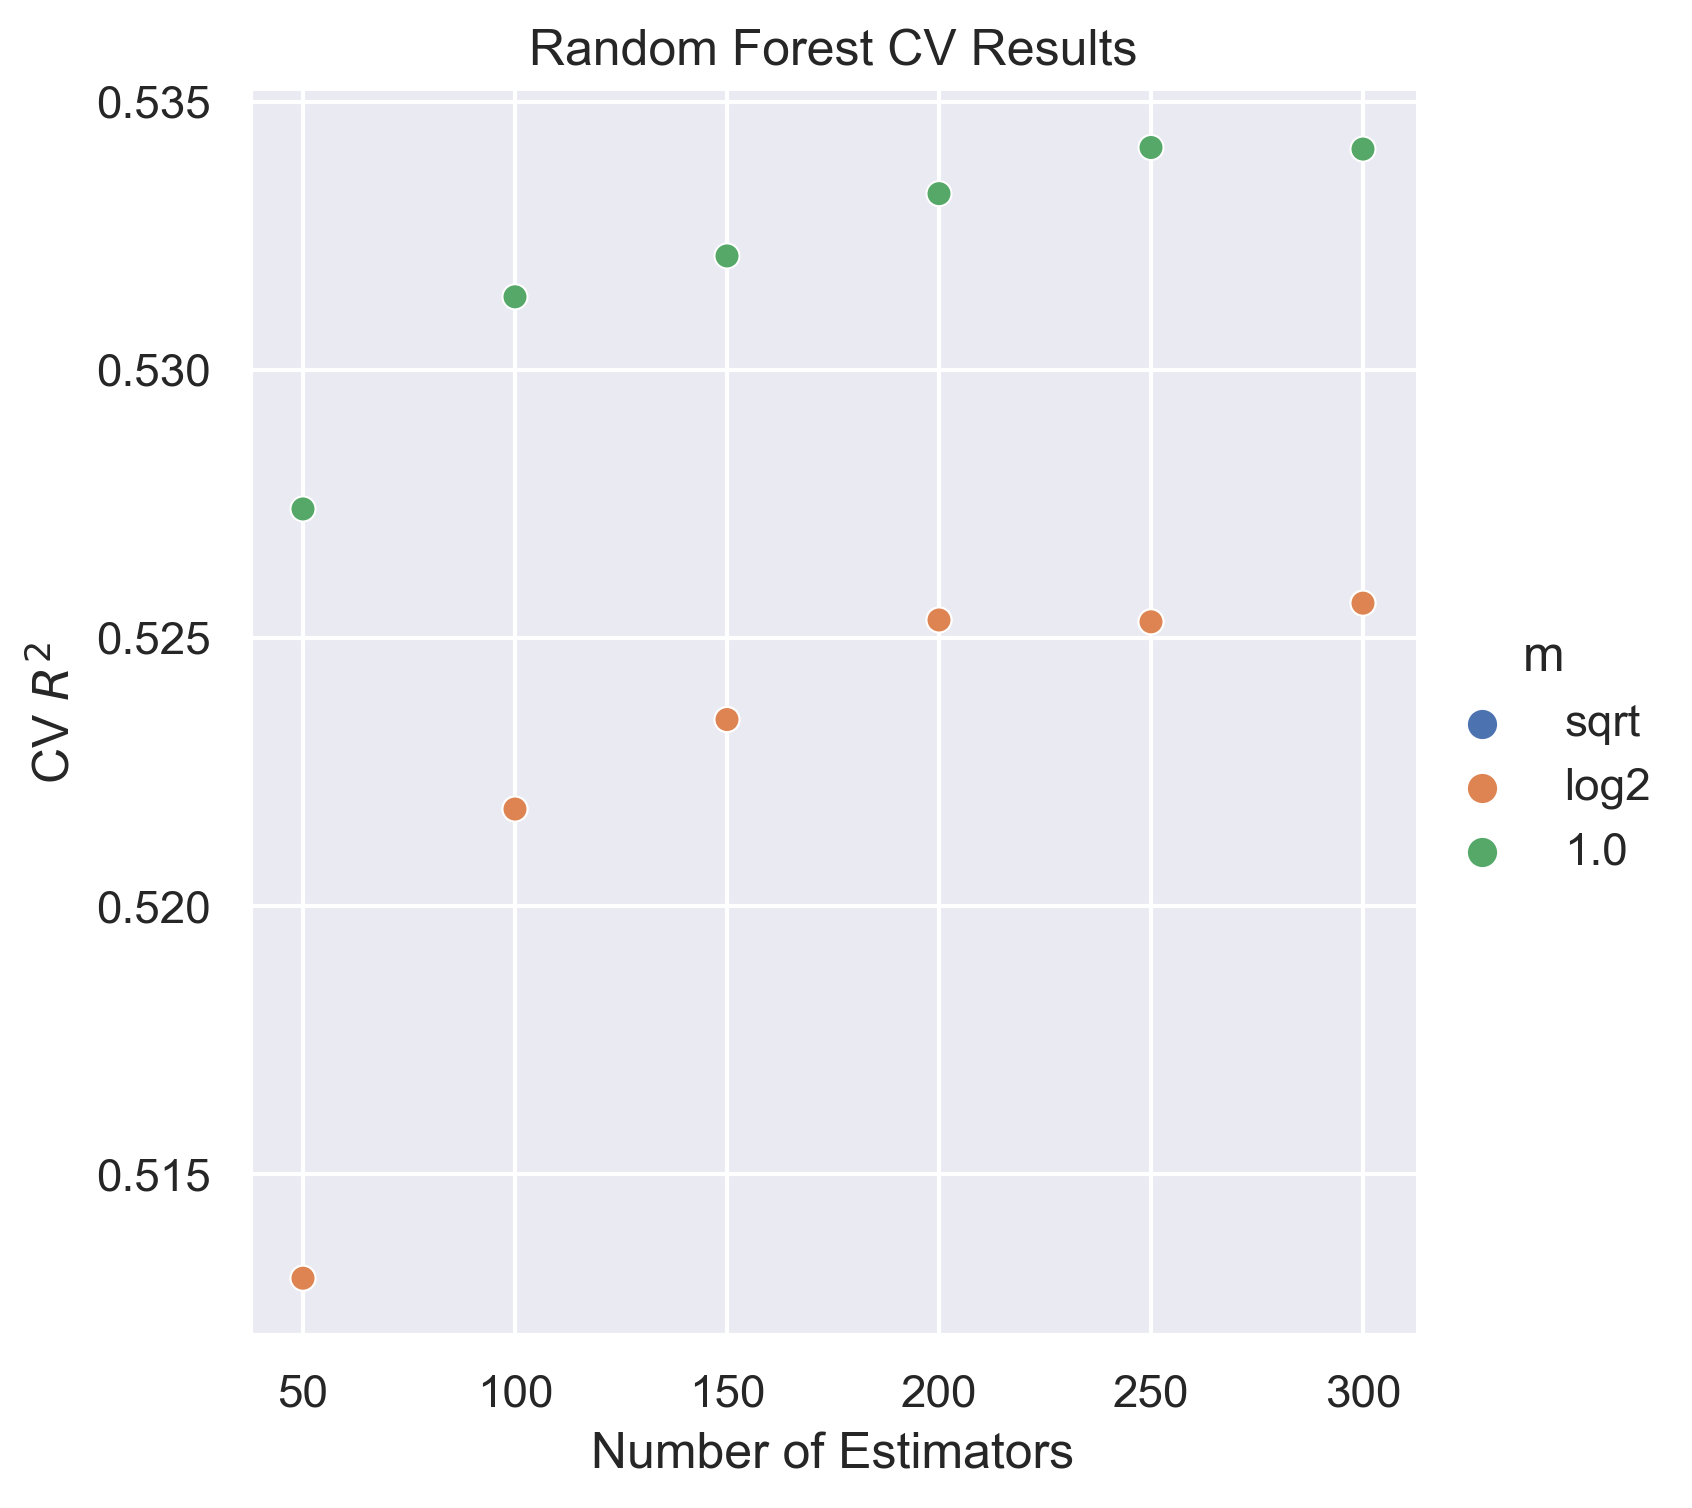

Best CV R2 Score:  0.5341433377350556


In [40]:
# CV Visualization
cv_res_rf = pd.DataFrame({
  "B": np.array(search_rf.cv_results_["param_model__n_estimators"]),
  "r2": search_rf.cv_results_["mean_test_score"],
  "m": search_rf.cv_results_["param_model__max_features"]
  })

plt.figure()
sns.relplot(
  # kind = "line",
  data = cv_res_rf,
  x = "B",
  y = "r2",
  hue = "m",
  ).set(
    xlabel = "Number of Estimators",
    ylabel = "CV $R^2$",
    title = "Random Forest CV Results"
)
plt.show()
cv_r2_rf = search_rf.best_score_
print('Best CV R2 Score: ', cv_r2_rf)

We find that the best model here actualy allows for an unrestricted max feature count and 250 trees. This is somewhat surprising since typically the square root method is used.

In [36]:
# Finalize Model
search_rf.best_estimator_

Pipeline(steps=[('model',
                 RandomForestRegressor(n_estimators=250, oob_score=True,
                                       random_state=425))])

In [39]:
# Final Testing R^2
rf_r2 = r2_score(
    y_test,
    search_rf.best_estimator_.predict(X_test))
print('Random Forest R2: ', rf_r2)

Random Forest R2:  0.39991323646588395


Ultimately, we find that Random Forest deliver performance very similar (but slightly worse) to that of our previous methods with a testing $R^2$ of about 0.4.

## Boosting forecaster (30pts)

Lastly, we use the same features as in AR($L$) for the boosting. We tune the boosting algorithm and evaluate the test performance.

In [53]:
# Model
boost = AdaBoostRegressor(
    estimator = DecisionTreeRegressor(max_depth=3),
    n_estimators = 50, # will tune
    learning_rate = 1.0, # will tune
    random_state = 425
)

# Pipeline
pipe_bst = Pipeline(steps = [
    ("model", boost)
])
pipe_bst

Pipeline(steps=[('model',
                 AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=3),
                                   random_state=425))])

Below, we will tune on the max depth of our regression tree, the number of trees tested, and the learning rate of our boosting algorithm.

In [54]:
# Hyper-parameter Tuning
d_grid_reg = [
    DecisionTreeRegressor(max_depth = 6),
    DecisionTreeRegressor(max_depth = 8),
    DecisionTreeRegressor(max_depth = 10),
    DecisionTreeRegressor(max_depth = 12),
]
B_grid_reg = [200,300]
lambda_grid_reg = [0.2,0.4,0.6,0.8,1.0]
tuned_params = {
    "model__estimator": d_grid_reg,
    "model__n_estimators": B_grid_reg,
    "model__learning_rate": lambda_grid_reg
}

In [55]:
# Time Series Split
tscv = TimeSeriesSplit(n_splits=5)

# Cross Validation
search_bst_reg = GridSearchCV(
    pipe_bst,
    tuned_params,
    cv = tscv,
    scoring = "r2",
    refit = True
)

In [56]:
search_bst_reg.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('model',
                                        AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=3),
                                                          random_state=425))]),
             param_grid={'model__estimator': [DecisionTreeRegressor(max_depth=6),
                                              DecisionTreeRegressor(max_depth=8),
                                              DecisionTreeRegressor(max_depth=10),
                                              DecisionTreeRegressor(max_depth=12)],
                         'model__learning_rate': [0.2, 0.4, 0.6, 0.8, 1.0],
                         'model__n_estimators': [200, 300]},
             scoring='r2')

<Figure size 1920x1440 with 0 Axes>

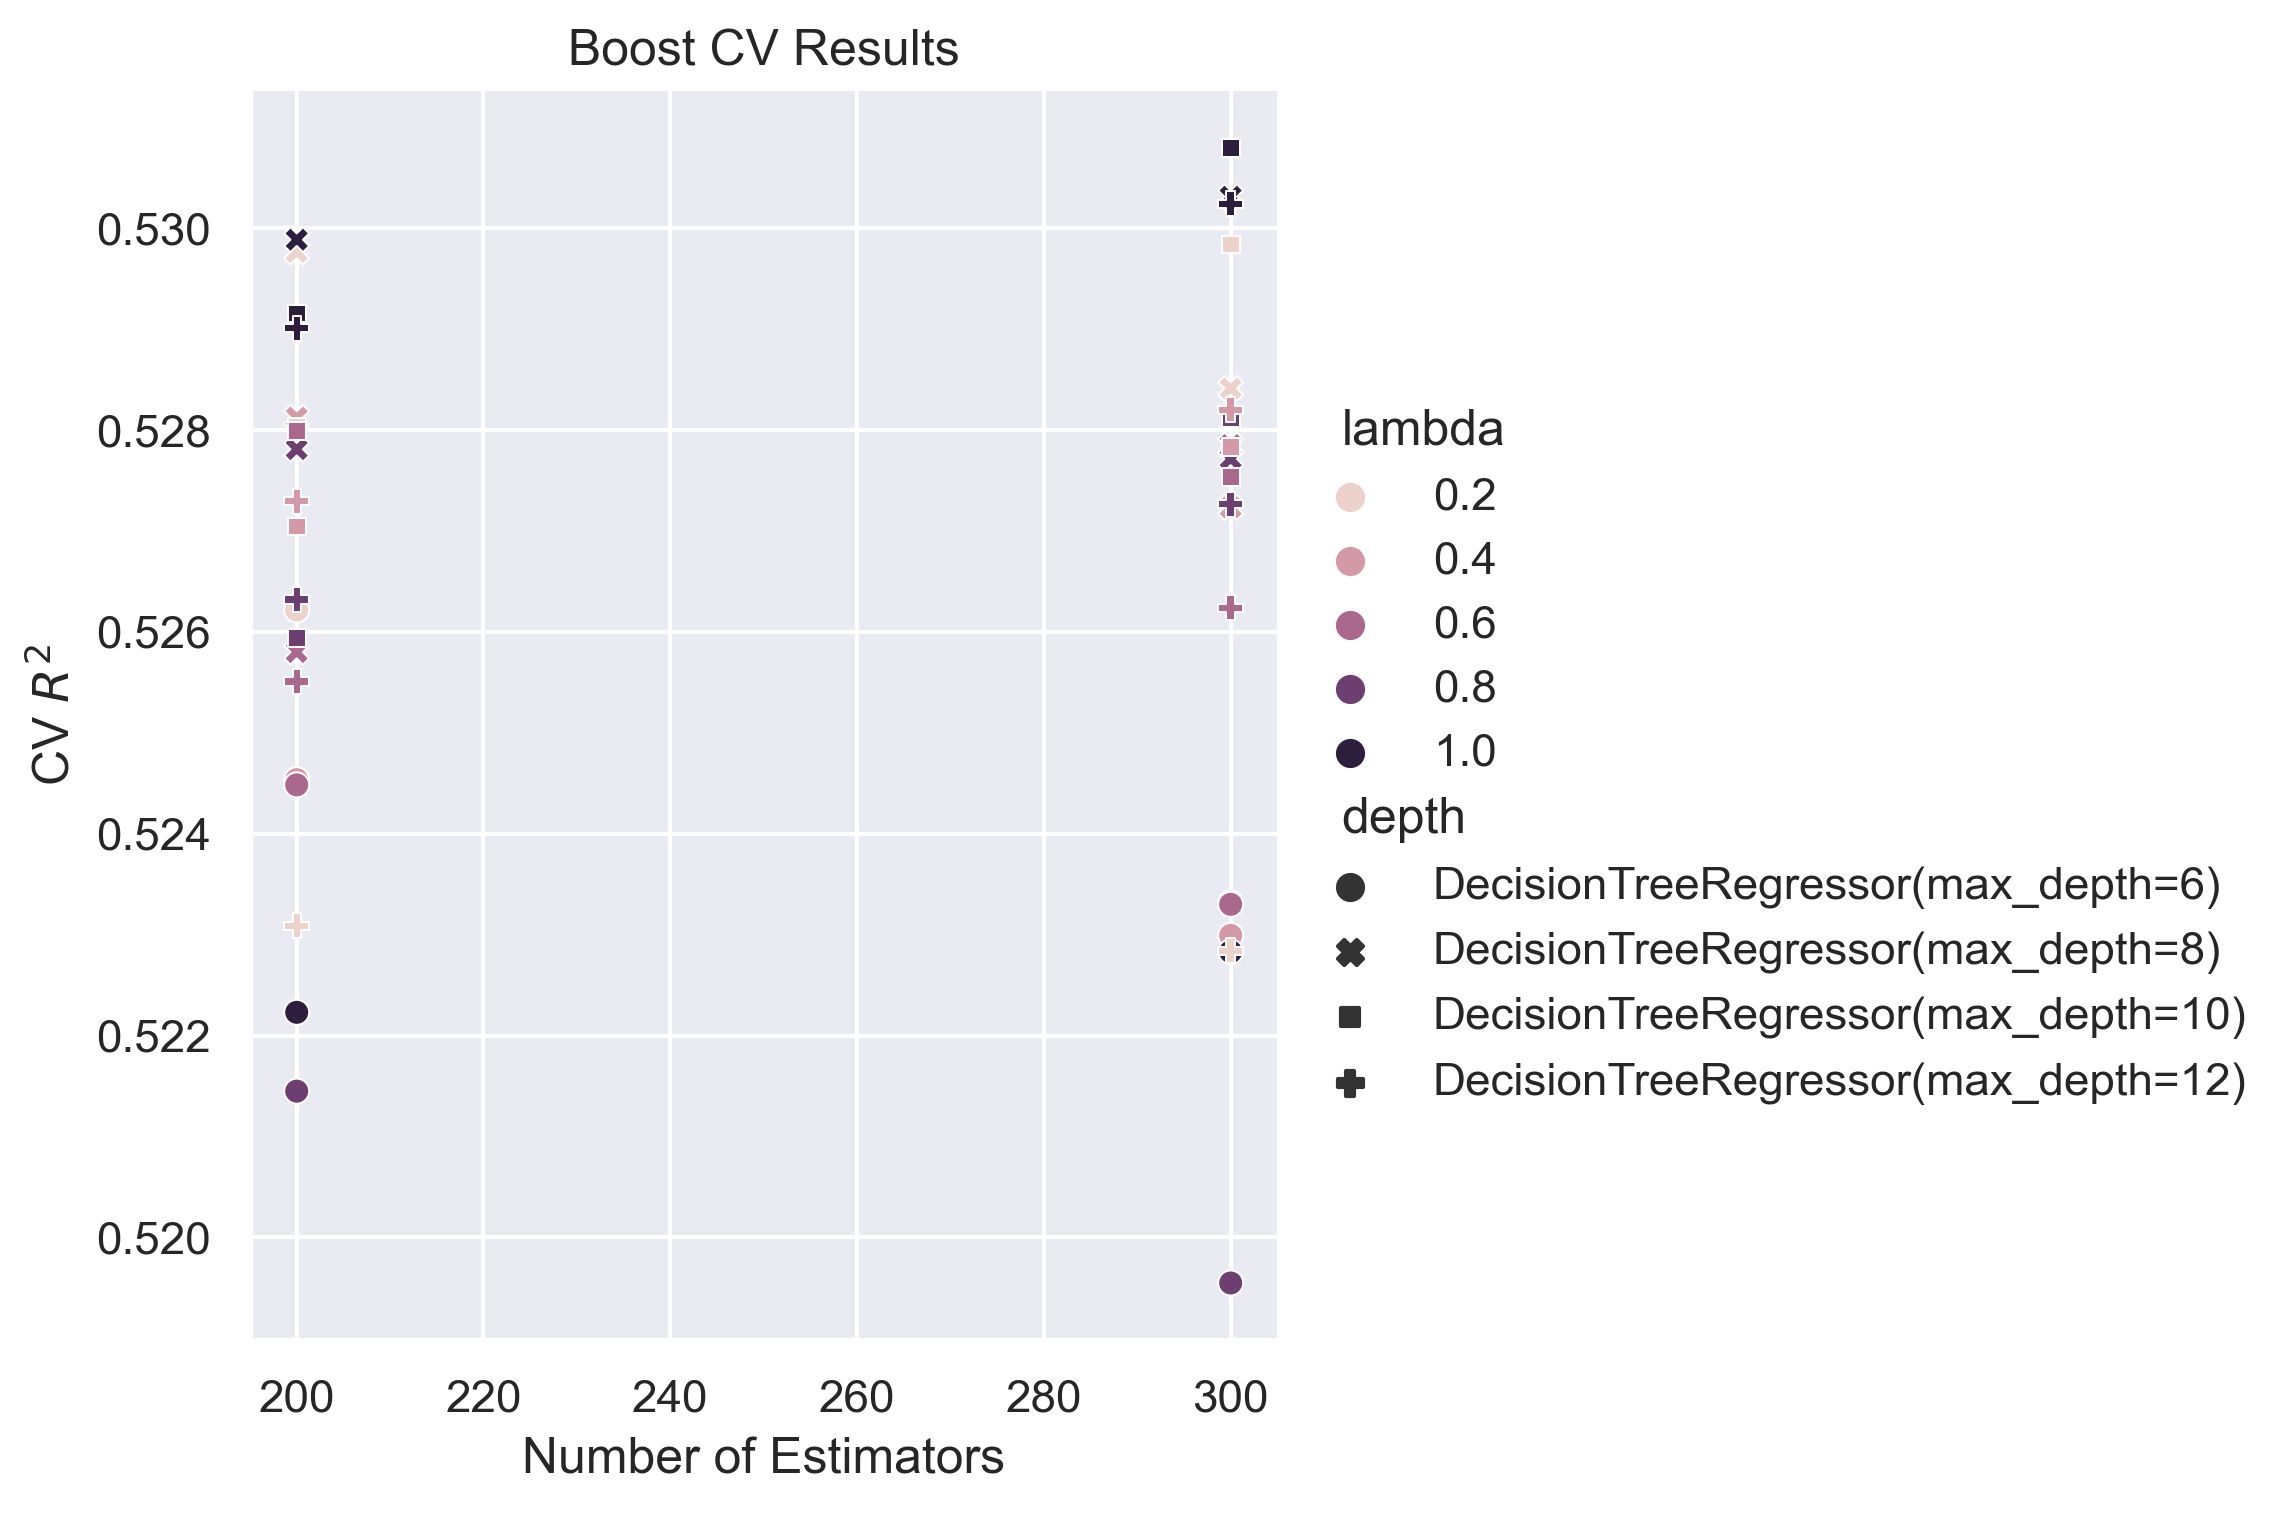

Best CV R2 Score:  0.530797163050597


In [57]:
# Visualize CV Results
cv_res_bst = pd.DataFrame({
  "B": np.array(search_bst_reg.cv_results_["param_model__n_estimators"]),
  "r2": search_bst_reg.cv_results_["mean_test_score"],
  "lambda": search_bst_reg.cv_results_["param_model__learning_rate"],
  "depth": search_bst_reg.cv_results_["param_model__estimator"],
  })

plt.figure()
sns.relplot(
  # kind = "line",
  data = cv_res_bst,
  x = "B",
  y = "r2",
  hue = "lambda",
  style = "depth"
  ).set(
    xlabel = "Number of Estimators",
    ylabel = "CV $R^2$",
    title = "Boost CV Results"
)
plt.show()
cv_r2_bst = search_bst_reg.best_score_
print('Best CV R2 Score: ', cv_r2_bst)

For computational reasons, we consider a smaller set of possible number of estimators. However, from this, we see that 300 estimators with a max depth of 10 and a high learning rate seem to perform best.

In [58]:
# Finalize Model
search_bst_reg.best_estimator_

Pipeline(steps=[('model',
                 AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=10),
                                   n_estimators=300, random_state=425))])

In [59]:
# Final Testing R^2
bst_r2 = r2_score(
    y_test,
    search_bst_reg.best_estimator_.predict(X_test))
print('Boost R2: ', bst_r2)

Boost R2:  0.3948230345234405


Ultimately, our boosted tree model delivers a similar $R^2$ as our previous models at about 0.395.

## Summary (30pts)

Below we present a summary of our results first in graph form, then in table form. Note that our graph has 0 values for the CV $R^2$ of the strawman and LSTM models.

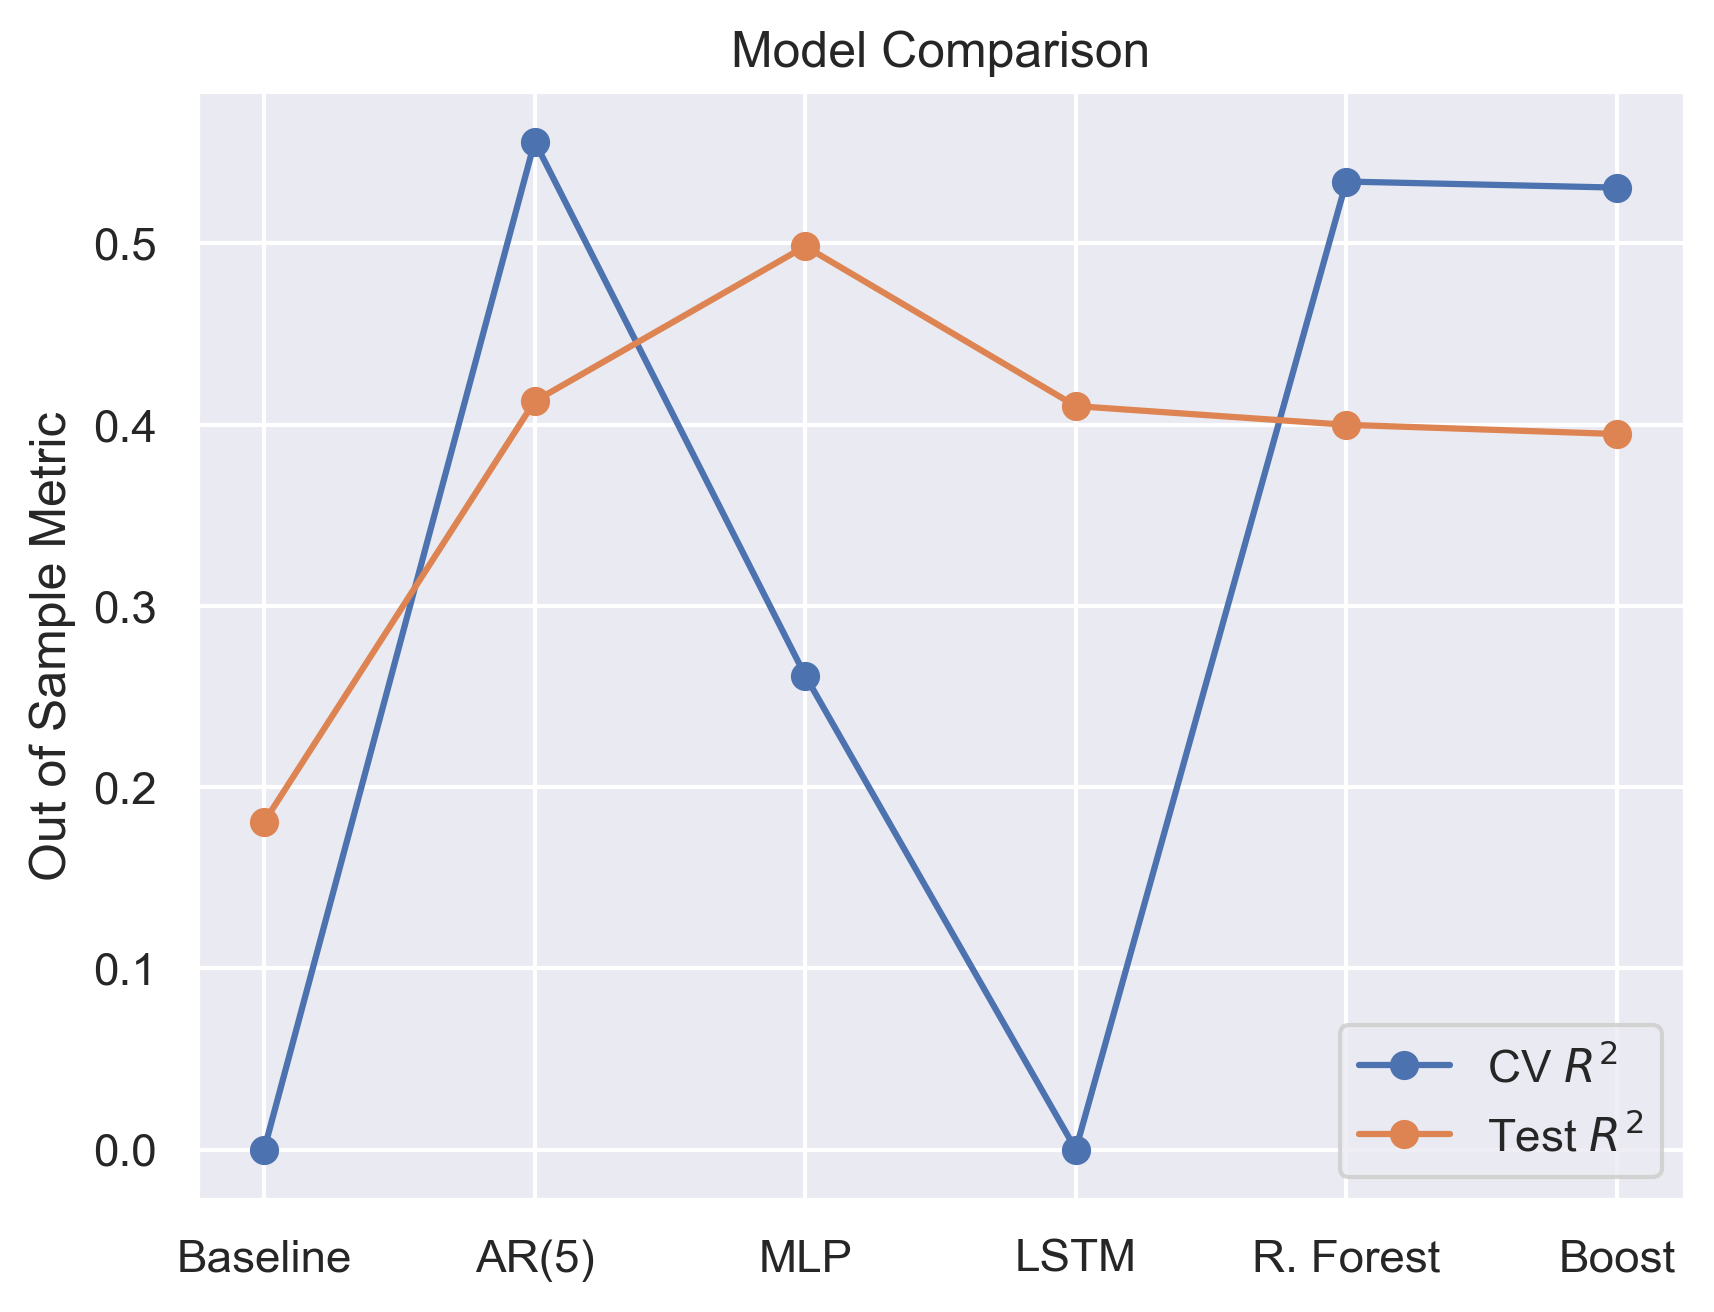

['Baseline', 'AR(5)', 'MLP', 'LSTM', 'R. Forest', 'Boost']
CV R2 Scores:  [0, 0.5562329203092148, 0.2615247042852141, 0, 0.5341433377350556, 0.530797163050597]
Test R2 Scores:  [0.18073700785807378, 0.41290503280129076, 0.4983900979507502, 0.4102404270052674, 0.39991323646588395, 0.3948230345234405]


In [82]:
# Model Metrics
model_types = ['Baseline', 'AR(5)', 'MLP',
                     'LSTM', 'R. Forest', 'Boost']
cv_r2 = [0, cv_r2_en, cv_r2_mlp, 0,
         cv_r2_rf, cv_r2_bst]
test_r2 = [r2_strawman, en_r2, mlp_r2, lstm_r2,
           rf_r2, bst_r2]

plt.plot(
    model_types,
    cv_r2,
    'o-', label="CV $R^2$")
plt.plot(
    model_types,
    test_r2,
    'o-', label="Test $R^2$")
plt.ylabel('Out of Sample Metric')
plt.title('Model Comparison')
plt.legend()
plt.show()

print(model_types)
print('CV R2 Scores: ', cv_r2)
print('Test R2 Scores: ', test_r2)

| Method | CV $R^2$ | Test $R^2$ |
|:------:|:------:|:------:|
| Baseline | n/a | 0.181 |
| AR(5) | 0.556 | 0.413 |
| AR(5) MLP | 0.262 | 0.498 |
| LSTM | n/a | 0.410 |
| Random Forest | 0.534 | 0.399 |
| Boosting | 0.531 | 0.395 |

From the above table, we see that all of our methods significantly outperformed the baseline method. And within our models, most performed very similarly. However, with our specification, we found that the AR(5) MLP model actually performed the best on the testing set despite having the worst CV $R^2$.